In [178]:
import pandas as pd
from scipy import stats
import numpy as np
import sqlite3
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from math import pi

def exp_format(x, pos=None):
    names = {1: 'Delay',
            2: 'Delay PD',
            3: 'No delay'}
    return names[x]

In [63]:
conn = sqlite3.connect("data.db")
act = pd.read_sql_query("select rowid, * from actors where valid=1;", conn)

## Recorded data

In [64]:
all_act = pd.read_sql_query("select * from actors where valid=1;", conn)
all_hits = pd.read_sql_query("select * from hits where valid=1;", conn)
all_survey = pd.read_sql_query("select * from survey where valid=1;", conn)
print('A total of {} data points were collected'.format(all_act.size+all_hits.size+all_survey.size))

A total of 11865 data points were collected


## Task times

In [65]:
times = pd.read_sql_query("select start, end from actors where valid=1;", conn)
length = np.array(times['end']-times['start'])
minutes = length.mean()/60-length.mean()/60%1
seconds = (length.mean()/60)%1*60
minutes_std = length.std()/60-length.std()/60%1
seconds_std = (length.std()/60)%1*60


print('Subjects used on average {:.0f} minutes and {:.0f} seconds with a standard deviation of {:.0f}min and {:.0f}s'
     .format(minutes, seconds, minutes_std, seconds_std))

Subjects used on average 10 minutes and 56 seconds with a standard deviation of 1min and 12s


## Demographics

In [66]:
valid_n = len(pd.read_sql_query("select age, gender, education, computer, eye from actors where valid=1;", conn))
non_valid = pd.read_sql_query("select age, gender, education, computer, eye from actors where valid=0;", conn)
female = pd.read_sql_query("select age, gender, education, computer, eye from actors where gender=1;", conn)
ages_df = pd.read_sql_query("select age from actors where valid=1;", conn)
ages = np.array(ages_df)
game = []
for i in range(5):
    query = "select * from actors where valid=1 and game={};".format(i)
    game.append(len(pd.read_sql_query(query, conn)))


print('{} total participants, {} excluded'.format(valid_n+len(non_valid),len(non_valid) ))
print('{:.1f}% females'.format(len(female)/valid_n*100))
print('Average age of {:.1f} years with a STD of {:.2f}'.format(float(ages.mean(axis=0)), float(ages.std(axis=0))))
print('100% said they use computer on a daily basis ')
print('Gaming: daily {:.0f}%, weekly {:.0f}%, monthly {:.0f}%, yearly {:.0f}% and never {:.0f}%'.format(*[i/valid_n*100 for i in game]))

58 total participants, 1 excluded
35.1% females
Average age of 24.7 years with a STD of 1.45
100% said they use computer on a daily basis 
Gaming: daily 4%, weekly 26%, monthly 14%, yearly 30% and never 26%


## Performance

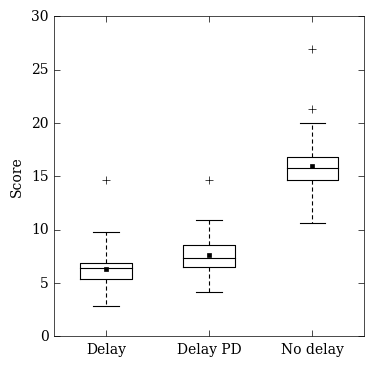

In [77]:
filename = 'performance_norm'
plt.style.use('classic')
plt.style.use('thesis.mplstyle')

hits = np.array(act[['tothitsexp0', 'tothitsexp1', 'tothitsexp2', 'tothits']]).astype(float)
norm = np.zeros((hits.shape[0],3))
avg = hits.mean(axis=0)
for i, row in enumerate(hits):
    norm[i,0] = row[0]/row[3]*avg[3]
    norm[i,1] = row[1]/row[3]*avg[3]
    norm[i,2] = row[2]/row[3]*avg[3]

fig, ax = plt.subplots(figsize=(4,4))
ax.boxplot(norm, whis=2, widths=0.5)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(exp_format))
plt.ylabel('Score')
plt.show()
# fig.savefig('../img/{}.png'.format(filename), bbox_inches='tight')

### Significance, Paired sample t-test and Cohen's D

In [107]:
from numpy import std, mean, sqrt

def welch_dof(x,y):
    dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
    return dof

def dependent_dof(x,y):
    return (len(x)+len(y))/2-1

def cohen_d(x,y):
    x = x.tolist()
    y = y.tolist()
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)

def print_sig(a, b):    
    t_stat, p_value = stats.ttest_rel(b, a)
    d_value = cohen_d(b, a)

    if p_value < 0.001:
        print('t({:.0f})={:.2f}, p<.001, d={:.3f}'.format(dependent_dof(a, b), t_stat, d_value))
    else:
        print('t({:.0f})={:.2f}, p={:.3f}, d={:.3f}'.format(dependent_dof(a, b), t_stat, p_value, d_value))

print_sig(norm[...,0], norm[...,1])


t(56)=4.82, p<.001, d=0.735


#### Table values

In [69]:
means = norm.mean(axis=0)

x = np.reshape(np.reciprocal(means), (3,1))
y = np.reshape(means, (1,3))
change = np.dot(x,y)-1
change = change.T

d = {'experiment':[exp_format(i+1) for i in range(3)],
    'mean':means,
    'std':norm.std(axis=0),
    'max':norm.max(axis=0),
    'min':norm.min(axis=0),
     'median':np.median(norm, axis=0),
    'diff_delay':change[...,0],
    'diff_pd':change[...,1],
    'diff_normal':change[...,2],
    }
table = pd.DataFrame(data=d)
table

,diff_delay,diff_normal,diff_pd,experiment,max,mean,median,min,std
0,0.000000,-0.605238,-0.168667,Delay,14.684211,6.320525,6.384439,2.842105,1.751276
1,0.202887,-0.525146,0.000000,Delay PD,14.684211,7.602880,7.342105,4.195489,1.706740
2,1.533175,0.000000,1.105912,No delay,26.921053,16.010994,15.813765,10.679426,2.531100


In [70]:
print('Mean differences for score compared to all experiments\n{}'.format('-'*57))
print('{:9} {:>15} {:>15} {:>15}'.format('', *(exp_format(i+1) for i in range(3))))
for idx, row in table.iterrows():
    print('{:9} {:>14.2f}% {:>14.2f}% {:>14.2f}%'.format(exp_format(idx+1), 
                                           row['diff_delay']*100, 
                                           row['diff_pd']*100, 
                                           row['diff_normal']*100))

Mean differences for score compared to all experiments
---------------------------------------------------------
                    Delay        Delay PD        No delay
Delay               0.00%         -16.87%         -60.52%
Delay PD           20.29%           0.00%         -52.51%
No delay          153.32%         110.59%           0.00%


## Load index

#### Absolute

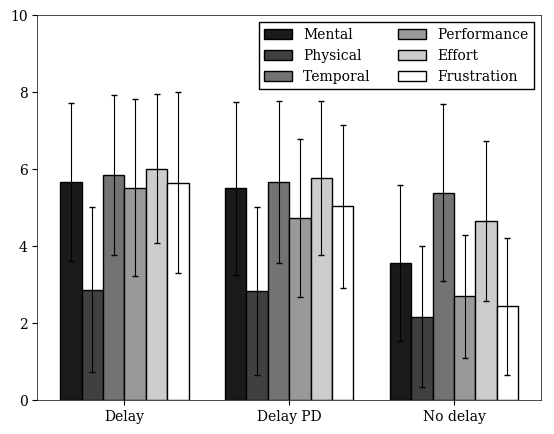

In [101]:
tlx_metrics = ['Mental', 'Physical', 'Temporal', 'Performance', 'Effort', 'Frustration']
filename = 'nasa_tlx_bar'
plt.style.use('default')
plt.style.use('thesis.mplstyle')

n_partic = pd.read_sql_query("select rowid from actors where valid=1 ;", conn).size
fig1, ax1 = plt.subplots(figsize=(6.5,5))
tlx_answers = []

bar_width= 0.13

for idx, metric in enumerate(tlx_metrics):
    data = np.zeros([n_partic,3])
    for exp in range(3):
        load = pd.read_sql_query("select {} from survey where valid=1 and experiment={};"
                                 .format(metric, exp), conn)
        data[...,exp] = np.reshape(np.array(load),(57,))
    if metric == 'Performance':
        data = np.ones_like(data)*10-data
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    x_pos = np.arange(3)+1 - bar_width*3 +idx*bar_width+bar_width/2
    tlx_answers.append(data)
    
    ax1.bar(x_pos, mean, bar_width, yerr=std, label=metric, 
            edgecolor='k', 
            linewidth=1,
           capsize=2,
           error_kw={'linewidth':0.8})


ax1.xaxis.set_major_formatter(ticker.FuncFormatter(exp_format))
ax1.set_xticks(np.arange(3)+1)
plt.ylim(0,10)
plt.legend(ncol=2)
plt.show()
# fig1.savefig('../img/{}.png'.format(filename), bbox_inches='tight')

#### Significance

In [222]:
metric = 3
g0 = tlx_answers[metric][...,0]
g1 = tlx_answers[metric][...,1]
print_sig(g1, g0)
answers_means = np.copy(tlx_answers[metric]).mean(axis=0)
print(answers_means)
print('{:.0f}% decrease in subjective latency using predictor screen'.format((1-answers_means[1]/answers_means[0])*100))

t(56)=3.24, p=0.002, d=0.360
[5.52631579 4.73684211 2.70175439]
14% decrease in subjective latency using predictor screen


## Delay times

In [197]:
data = pd.DataFrame()
for exp in range(3):
    data[exp] = pd.read_sql_query("select delay from survey where valid=1 and experiment={} order by actor asc;".format(exp), conn)
times = np.array(data)

### Absolute

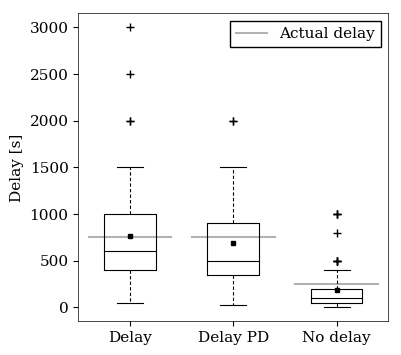

In [237]:
filename = 'subjective_delay_abs'
matplotlib.rcParams.update({'font.size': 11})
fig, ax = plt.subplots(figsize=(4,4))
ax.boxplot(times, widths=0.5)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(exp_format))
ax.plot([0.6,1.4], [750, 750], 'k', alpha=0.3, label='Actual delay')
ax.plot([1.6,2.4], [750, 750], 'k', alpha=0.3)
ax.plot([2.6,3.4], [250, 250], 'k', alpha=0.3)
ax.legend()
plt.ylabel('Delay [s]')
plt.show()
# fig.savefig('../img/{}.png'.format(filename), bbox_inches='tight')

### Normalized

In [211]:
sums = times.sum(axis=1)
averages = np.copy(times).mean(axis=0)
normalized = np.copy(times)
for idx, row in enumerate(normalized):
    row[0] = row[0]/sums[idx]*averages[0]
    row[1] = row[1]/sums[idx]*averages[1]
    row[2] = row[2]/sums[idx]*averages[2]

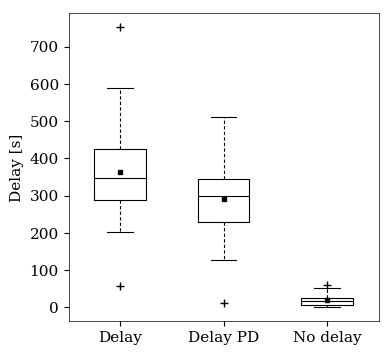

In [212]:
filename = 'subjective_delay_norm'
fig, ax = plt.subplots(figsize=(4,4))
ax.boxplot(normalized, widths=0.5)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(exp_format))
plt.ylabel('Delay [s]')
plt.show()
# fig.savefig('../img/{}.png'.format(filename), bbox_inches='tight')

In [219]:
norm_avg = np.copy(normalized).mean(axis=0)
print('{:.0f}% decrease in subjective latency using predictor screen'.format((1-norm_avg[1]/norm_avg[0])*100))
print_sig(normalized[...,1], normalized[...,0])

20% decrease in subjective latency using predictor screen
t(56)=2.71, p=0.009, d=0.687


## Key presses

In [238]:
data = pd.read_sql_query("select keydowns0, keydowns1, keydowns2 from actors where valid=1;", conn)
keys = np.array(data)

#### Absolute

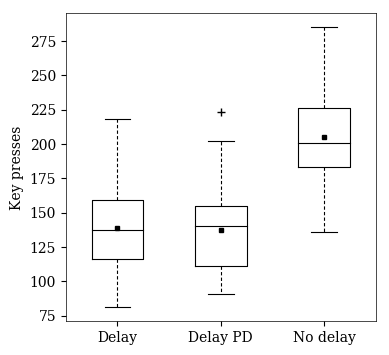

In [246]:
filename = 'keypresses'
matplotlib.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(figsize=(4,4))
ax.boxplot(keys, widths=0.5)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(exp_format))
plt.ylabel('Key presses')
plt.show()
fig.savefig('../img/{}.png'.format(filename), bbox_inches='tight')

#### Score relationship

R=-0.089, p=0.511, stderr=0.007


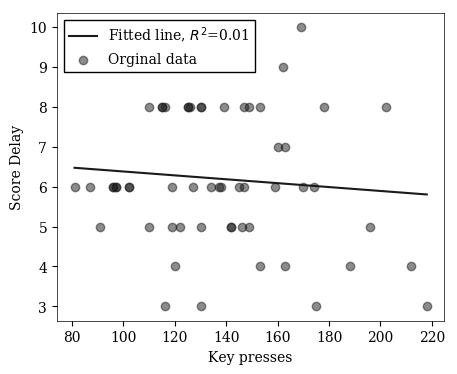

R=0.152, p=0.260, stderr=0.008


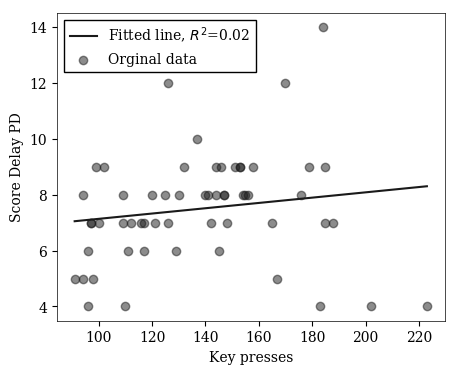

R=0.533, p=<0.001, stderr=0.013


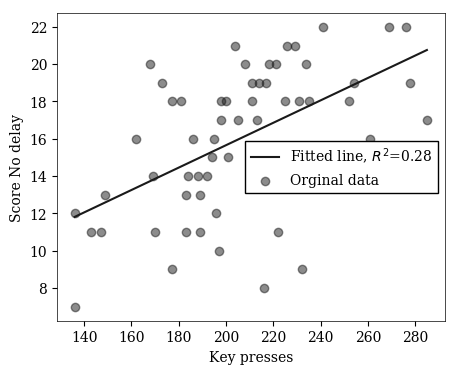

In [306]:
def print_stats(r, p, stderr):    
    if p < 0.001:
        print('R={:.03f}, p=<0.001, stderr={:.03f}'.format(r, stderr))
    else:
        print('R={:.03f}, R^2={:.03f}, p={:.03f}, stderr={:.03f}'.format(r, r**2, p, stderr))

columns = 'tothitsexp0, tothitsexp1, tothitsexp2, keydowns0, keydowns1, keydowns2'
data = pd.read_sql_query("select {} from actors where valid=1;".format(columns), conn)
array = np.array(data)
from scipy.stats import linregress

for disp in range(3):
    filename = 'score_key_relationship_'+str(disp)
    x = array[...,disp+3]
    y = array[...,disp]
    linreg = linregress(x,y)
    x_min = min(x)
    x_max = max(x)+1
    print_stats(linreg.rvalue, linreg.pvalue, linreg.stderr)
    
    fig, ax = plt.subplots(figsize=(5,4))
    ax.scatter(x,y, marker='o', alpha=0.5, label='Orginal data')
    ax.plot(np.arange(x_min, x_max), np.arange(x_min, x_max)*linreg.slope+linreg.intercept, label='Fitted line, $R^2$={:.2f}'
            .format(linreg.rvalue**2))
    plt.xlabel('Key presses')
    plt.ylabel('Score {}'.format(exp_format(disp+1)))
    plt.legend()
    plt.show()
#     fig.savefig('../img/{}.png'.format(filename), bbox_inches='tight')